# Análise Exploratória de Dados com Python e SQL

Elaboração de perguntas para serem respondidas usando a database do IMDB de filmes, séries, programas de TV, etc.

### Instalando e Carregando Pacotes

In [ ]:
# Instalando os pacotes necessários
!pip install -q imdb-sqlite
!pip install -q pycountry

In [1]:
# Importando as bibliotecas
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer

### Carregando os Dados

In [2]:
# Baixando a database
!imdb-sqlite

2022-06-11 14:32:43,930 DB already exists: (imdb.db). Refusing to modify. Exiting


In [3]:
# Conectando no banco de dados
conn = sqlite3.connect('imdb.db')

In [4]:
# Extraindo a lista de tabelas do database
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

# Visualizando o resultado
print(tabelas.shape)
tabelas.head(6)

(6, 1)


,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [5]:
# Convertendo o dataframe de tabelas em uma lista
tabelas = tabelas['Table_Name'].values.tolist()

In [6]:
# Percorrendo a lista de tabelas do database para extrair o esquema de cada uma
for tabela in tabelas:
    consulta = 'PRAGMA TABLE_INFO({})'.format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print('Esquema da tabela:', tabela)
    display(resultado)
    print('\n')

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0




Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0




Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0




Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0




Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0




Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


### 1. Quais são as categorias de shows mais comuns no IMDB?

In [7]:
# Consulta SQL
con1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [8]:
# Extrai o resultado
res1 = pd.read_sql_query(con1, conn)

In [9]:
# Visualizando o resultado
display(res1)

,type,COUNT
0,movie,610703
1,short,870502
2,tvEpisode,6711134
3,tvMiniSeries,43485
4,tvMovie,136129
5,tvPilot,2
6,tvSeries,225314
7,tvShort,10541
8,tvSpecial,36991
9,video,260813


In [10]:
# Calculando o percentual de cada tipo em relação ao total
res1['percentual'] = (res1['COUNT'] / res1['COUNT'].sum()) * 100
display(res1)

,type,COUNT,percentual
0,movie,610703,6.833597
1,short,870502,9.740676
2,tvEpisode,6711134,75.095728
3,tvMiniSeries,43485,0.486585
4,tvMovie,136129,1.523246
5,tvPilot,2,0.000022
6,tvSeries,225314,2.521201
7,tvShort,10541,0.117951
8,tvSpecial,36991,0.413919
9,video,260813,2.918425


In [11]:
# Criando um gráfico com 04 categorias:
# As primeiras 3 categorias com mais títulos e 1 categoria com todo o restante

# Dicionário vazio para as categorias restantes
others = {}

# Todas as categorias restantes tem menos de 5% de participação, então vamos filtar por essa porcentagem e somar
others['COUNT'] = res1[res1['percentual'] < 5]['COUNT'].sum()

# Gravando o percentual no dicionário
others['percentual'] = res1[res1['percentual'] < 5]['percentual'].sum()

# Ajustando o nome
others['type'] = 'others'

In [12]:
# Visualizando o dicionário
others

{'COUNT': 744433, 'percentual': 8.329998795985844, 'type': 'others'}

In [13]:
# Filtra o dataframe de resultado para buscar as 03 primeiras categorias
res1 = res1[res1['percentual'] > 5]

In [14]:
# Junta o dataframe com o dicionário de outras categorias
res1 = res1.append(others, ignore_index=True)

In [15]:
# Ordenando o dataframe e visualizando o resultado
res1 = res1.sort_values(by='COUNT', ascending=False)
res1.head()

,type,COUNT,percentual
2,tvEpisode,6711134,75.095728
1,short,870502,9.740676
3,others,744433,8.329999
0,movie,610703,6.833597


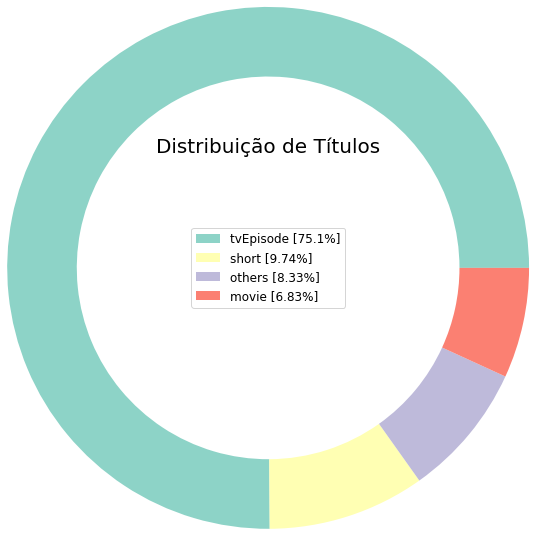

In [16]:
# Construindo e demonstrando o gráfico
# Ajusta as legendas do gráfico
labels = [str(res1['type'][i])+' '+'['+str(round(res1['percentual'][i], 2)) +'%'+']' for i in res1.index]

# Mapa de cores
cs = cm.Set3(np.arange(100))

# Pie Plot
f = plt.figure()
plt.pie(res1['COUNT'], labeldistance=1, radius=3, colors=cs, wedgeprops = dict(width=0.8))
plt.legend(labels=labels, loc='center', prop={'size':12})
plt.title('Distribuição de Títulos', loc='center', fontdict={'fontsize':20, 'fontweight':20})
plt.show()

### 2. Qual o número de filmes por gênero?

In [90]:
# Consulta SQL
con2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [91]:
# Resultado
res2 = pd.read_sql_query(con2, conn)

In [92]:
# Visualiza o resultado
display(res2)

,genres,COUNT(*)
0,Action,14031
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1458,"Thriller,Western",43
1459,War,1298
1460,"War,Western",14
1461,Western,5159


In [93]:
# Precisamos unificar os gêneros que tem palavras em comum
# Primeiro, converte as strings dos gêneros para minúsculo
res2['genres'] = res2['genres'].str.lower().values

# Depois, removemos os valores ausentes
temp = res2['genres'].dropna()

In [94]:
# Usaremos o CountVectorizer para converter a coluna de gêneros em um vetor e contar o número de filmes em cada gênero
# Vamos criar um vetor usando expressão regular para filtrar as strings
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

# Aplica a vetorização ao dataset sem os valores ausentes
bag_generos = vetor.transform(temp)

In [95]:
# Retorna os gêneros únicos
generos_unicos = vetor.get_feature_names()

In [96]:
# Cria o dataframa de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns=generos_unicos, index=temp.index)

In [97]:
# Visualiza os gêneros únicos
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1462
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1463 non-null   int64
 1   adult        1463 non-null   int64
 2   adventure    1463 non-null   int64
 3   animation    1463 non-null   int64
 4   biography    1463 non-null   int64
 5   comedy       1463 non-null   int64
 6   crime        1463 non-null   int64
 7   documentary  1463 non-null   int64
 8   drama        1463 non-null   int64
 9   family       1463 non-null   int64
 10  fantasy      1463 non-null   int64
 11  film-noir    1463 non-null   int64
 12  game-show    1463 non-null   int64
 13  history      1463 non-null   int64
 14  horror       1463 non-null   int64
 15  music        1463 non-null   int64
 16  musical      1463 non-null   int64
 17  mystery      1463 non-null   int64
 18  n            1463 non-null   int64
 19  news         1463 non-null   int64
 20  reality-

In [98]:
# Removemos a coluna n
generos = generos.drop(columns='n', axis=0)

In [99]:
# Calcula o percentual de cada gênero em relação ao todo
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]

In [100]:
generos_percentual.head(10)

drama          17.976760
comedy         16.883117
documentary    15.789474
adventure      14.900889
action         14.422420
romance        13.260424
crime          13.123718
mystery        12.508544
thriller       12.303486
fantasy        12.098428
dtype: float64

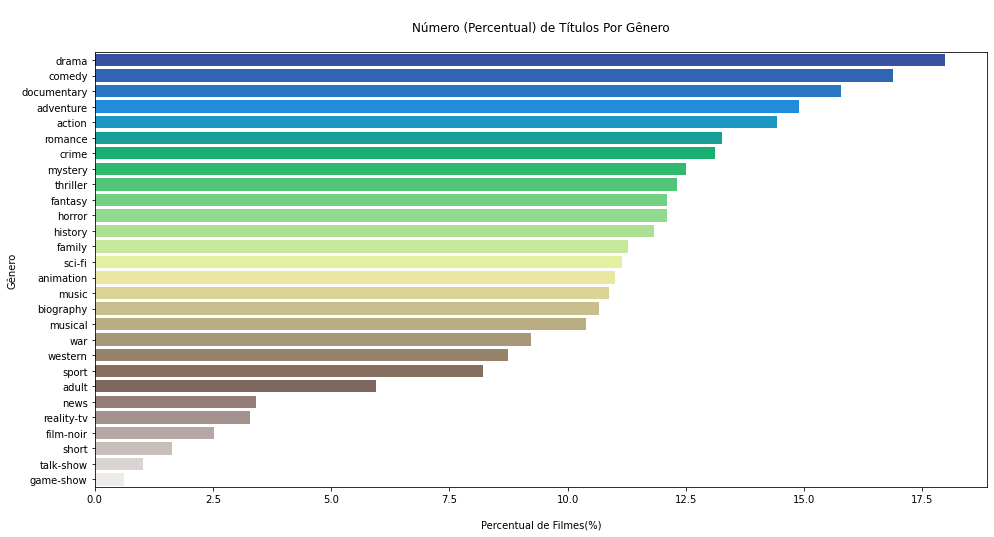

In [101]:
# Criando e visualizando o gráfico
plt.figure(figsize=(16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient='h', palette='terrain')
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de Filmes(%)')
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

### 3. Qual a mediana de avaliação dos filmes por gênero?

In [33]:
# Consulta SQL
con3 = '''SELECT rating, genres FROM ratings JOIN titles ON
          ratings.title_id = titles.title_id WHERE 
          premiered <= 2022 AND type = 'movie'
          '''

In [34]:
# Resultado
res3 = pd.read_sql_query(con3, conn)

In [35]:
# Visualizando o resultado
display(res3)

,rating,genres
0,4.5,\N
1,6.0,"Action,Adventure,Biography"
2,4.5,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
278469,5.8,Thriller
278470,6.4,"Drama,History"
278471,3.6,"Adventure,History,War"
278472,8.3,Drama


In [37]:
# Vamos criar uma função para retornar os gêneros únicos
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [38]:
# Aplica a função ao resultado
generos_unicos = retorna_generos(res3)

In [39]:
# Visualizando os gêneros após execução da função
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [40]:
# Criando listas vazias para a contagem de filmes e mediana da avaliação por gênero
genero_counts = []
genero_ratings = []

In [41]:
# Loop para preencher as listas
for item in generos_unicos:
    # Contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    # Mediana de avaliação dos filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [42]:
# Preparando o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [43]:
# Visualizando o dataframe criado
df_genero_ratings.head(20)

,genres,count,rating
0,action,28822,5.8
1,adult,4373,5.8
2,adventure,17505,6.0
3,animation,4784,6.5
4,biography,8482,7.0
5,comedy,68850,6.0
6,crime,23817,6.1
7,documentary,41653,7.3
8,drama,123321,6.3
9,family,10760,6.3


In [44]:
# Removendo o gênero news
df_genero_rating = df_genero_ratings.drop(index=18)

In [45]:
# Ordenando o resultado
df_genero_ratings = df_genero_ratings.sort_values(by='rating', ascending=False)

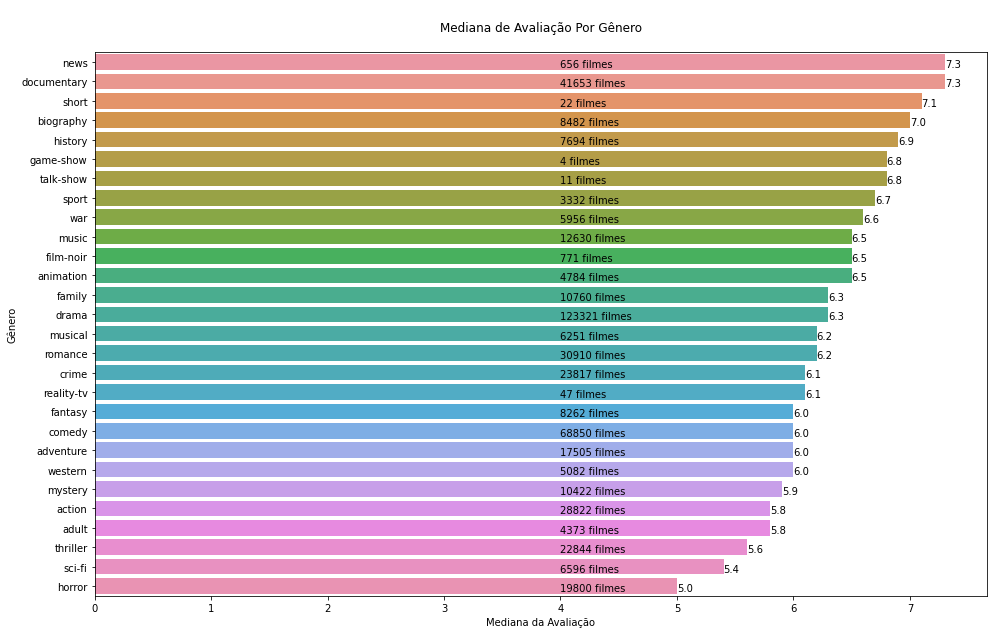

In [46]:
# Criando e visualizando o gráfico
plt.figure(figsize=(16,10))

sns.barplot(y=df_genero_ratings.genres, x=df_genero_ratings.rating, orient='h')

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + ' filmes')
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings['rating'][df_genero_ratings.index[i]],2))
plt.ylabel('Gênero')
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

### 4. Qual a mediana de avaliação dos filmes em relação ao ano de estréia?

In [47]:
# Consulta SQL
con4 = '''
       SELECT rating AS Rating, premiered FROM
       ratings JOIN titles ON ratings.title_id = titles.title_id
       WHERE premiered <= 2022 AND type = 'movie'
       ORDER BY premiered
       '''

In [48]:
# Resultado
res4 = pd.read_sql_query(con4, conn)

In [49]:
# Visualizando o resultado
display(res4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
278469,6.0,2022
278470,7.1,2022
278471,9.5,2022
278472,5.0,2022


In [50]:
# Calculando a mediana ao longo dos anos
ratings = []
for year in set(res4['premiered']):
    ratings.append(np.median(res4[res4['premiered'] == year]['Rating']))

In [51]:
# Visualizando parte da lista de ratings
ratings[:10]

[6.2, 4.5, 3.85, 5.85, 6.2, 3.4, 4.6, 5.3, 4.5, 3.6]

In [52]:
# Lista de Anos
anos = list(set(res4['premiered']))
anos[:10]

[1896, 1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

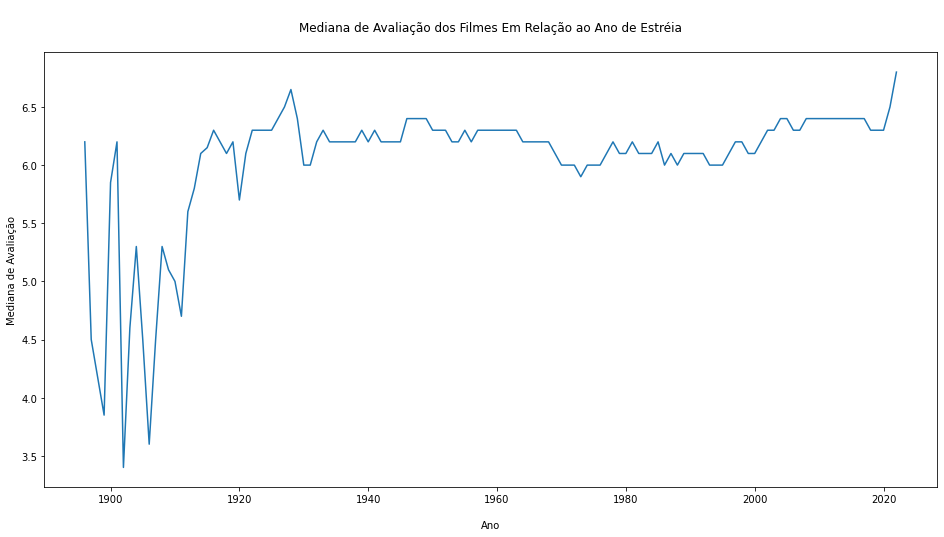

In [53]:
# Criando e visualizando o gráfico
plt.figure(figsize=(16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

### 5. Qual o número de filmes avaliados por gênero em relação ao ano de estréia?

In [54]:
# Consulta SQL
con5 = '''SELECT genres from titles'''

In [55]:
# Resultado
res5 = pd.read_sql_query(con5, conn)

In [56]:
# Visualizando
display(res5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8936767,"Action,Drama,Family"
8936768,"Action,Drama,Family"
8936769,"Action,Drama,Family"
8936770,Short


In [57]:
# Retorna os gêneros únicos através da função criada anteriormente
generos_unicos = retorna_generos(res5)

In [58]:
# Fazendo a contagem de filmes avaliados por gênero
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [59]:
# Preparando o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['count'] = genero_count

In [60]:
# Calculando somente o top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by='count', ascending=False)
top_generos = df_genero_count.head()['genre'].values

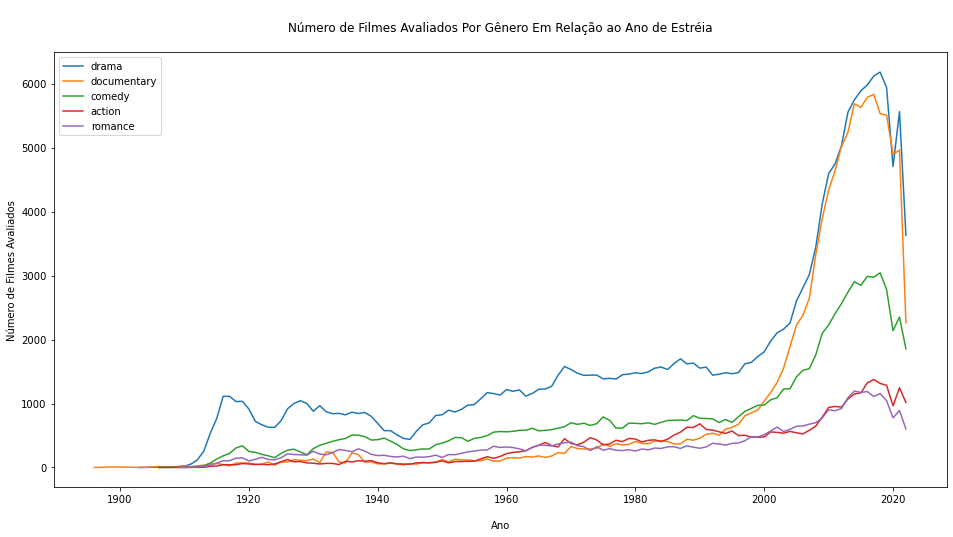

In [61]:
# Criando e visualizando o gráfico
plt.figure(figsize=(16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

### 6. Qual o filme com maior tempo de duração?

In [62]:
# Consulta
con6 = '''
       SELECT runtime_minutes AS Runtime, primary_title
       FROM titles
       WHERE type = 'movie' AND Runtime != 'NaN'
       ORDER BY Runtime DESC
       LIMIT 1
       '''

In [63]:
# Resultado
res6 = pd.read_sql_query(con6, conn)

In [64]:
# Visualizando
display(res6)

,Runtime,primary_title
0,51420,Logistics


'Logistics' é o filme mais longo da história (até este momento), com 857 horas (51420 minutos)

### 7. Qual a relação entre duração e gênero?

In [65]:
# Consulta SQL
con7 = '''
       SELECT AVG(runtime_minutes), genres
       FROM titles
       WHERE type = 'movie'
       AND runtime_minutes != 'NaN'
       GROUP BY genres
       '''

In [66]:
# Resultado
res7 = pd.read_sql_query(con7, conn)

In [67]:
# Visualiza
display(res7)

,AVG(runtime_minutes),genres
0,99.382494,Action
1,77.000000,"Action,Adult"
2,69.000000,"Action,Adult,Adventure"
3,74.000000,"Action,Adult,Comedy"
4,84.666667,"Action,Adult,Crime"
...,...,...
1371,93.928571,"Thriller,Western"
1372,94.028007,War
1373,90.000000,"War,Western"
1374,70.116722,Western


In [68]:
# Queremos somente os gêneros únicos, então usamos a função já criada
generos_unicos = retorna_generos(res7)

In [69]:
# Calculando a mediana de duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [70]:
# Criando e preparando o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [71]:
df_genero_runtime.head(20)

,genre,runtime
0,action,94.0
1,adult,78.0
2,adventure,90.0
3,animation,81.0
4,biography,87.0
5,comedy,91.0
6,crime,92.0
7,documentary,74.0
8,drama,93.0
9,family,89.0


In [72]:
# Removendo o gênero news
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [73]:
# Ordenando os dados
df_genero_runtime = df_genero_runtime.sort_values(by='runtime', ascending=False)

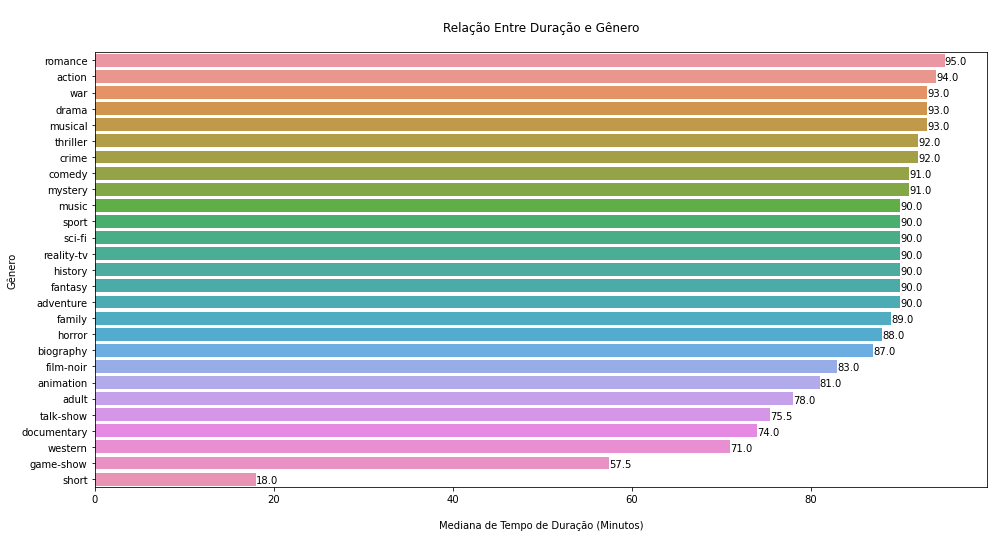

In [74]:
# Criando e visualizando o gráfico
plt.figure(figsize=(16,8))
sns.barplot(y = df_genero_runtime.genre, x=df_genero_runtime.runtime, orient='h')

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime['runtime'][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

### 8. Qual o número de filmes produzidos por país?

In [75]:
# Consulta SQL
con8 = '''
       SELECT region, COUNT(*) Number_of_movies FROM
       akas JOIN titles ON
       akas.title_id = titles.title_id
       WHERE region != 'None'
       AND type = \'movie\'
       GROUP BY region
       '''

In [76]:
# Resultado
res8 = pd.read_sql_query(con8, conn)

In [77]:
# Visualizando
display(res8)

,region,Number_of_movies
0,AD,22
1,AE,6628
2,AF,113
3,AG,12
4,AL,1287
...,...,...
229,YUCS,154
230,ZA,3267
231,ZM,15
232,ZRCD,2


In [78]:
# Listas auxiliares para obter o nome de países e contagem de filme por paíse
nomes_paises = []
contagem = []

In [79]:
# Loop para obter o país de acordo com a região
for i in range(res8.shape[0]):
    try:
        coun = res8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(res8['Number_of_movies'].values[i])
    except: 
        continue

In [80]:
# Criando e preparando o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['movie_count'] = contagem

In [81]:
# Ordenando o resultado
df_filmes_paises =df_filmes_paises.sort_values(by='movie_count', ascending=False)

In [82]:
# Visualizando os 10 primeiros
df_filmes_paises.head(10)

,country,movie_count
199,United States,312102
65,United Kingdom,159788
96,Japan,91582
63,France,85031
89,India,81837
32,Canada,78495
47,Germany,71131
58,Spain,65809
26,Brazil,65764
93,Italy,65677


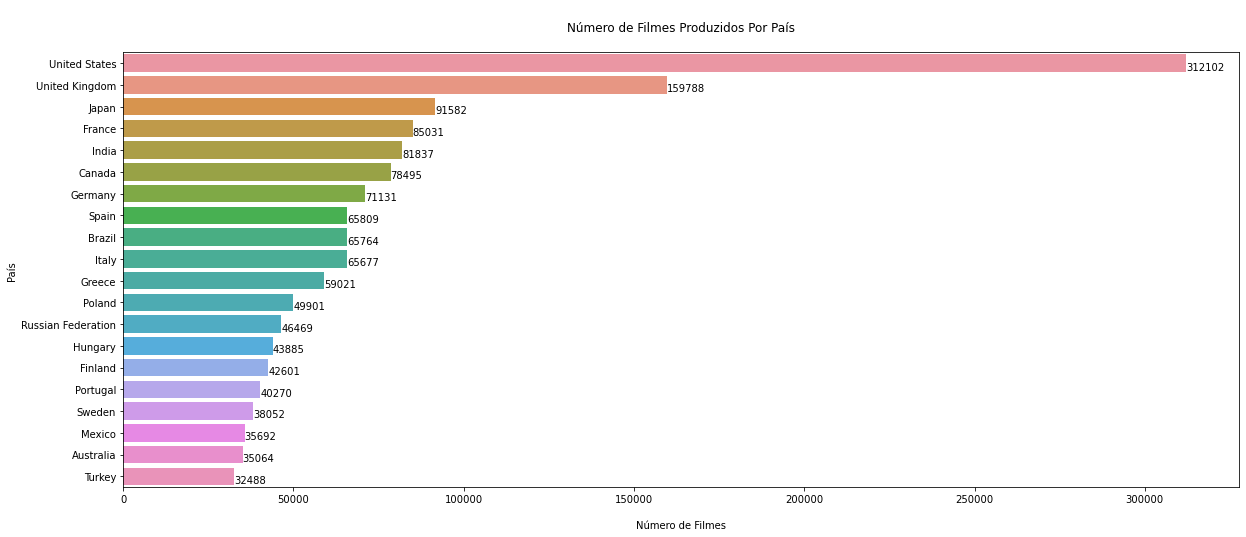

In [83]:
# Criando e visualizando o gráfico
plt.figure(figsize=(20,8))
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].movie_count, orient='h')

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.movie_count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises['movie_count'][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

### 9. Quais são os 10 melhores filmes?

In [84]:
# Consulta SQL - Filmes somente com mais de 25000 avaliações
con9 = '''
       SELECT primary_title AS movie_name, genres, rating
       FROM titles JOIN ratings
       ON titles.title_id = ratings.title_id
       WHERE titles.type = 'movie' AND ratings.votes >= 25000
       ORDER BY rating DESC
       LIMIT 10
       '''

In [85]:
# Resultado
res9 = pd.read_sql_query(con9, conn)

In [86]:
# Visualizando o top 10
display(res9)

,movie_name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
4,12 Angry Men,"Crime,Drama",9.0
5,The Godfather: Part II,"Crime,Drama",9.0
6,Schindler's List,"Biography,Drama,History",9.0
7,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
8,The Dark Knight,"Action,Crime,Drama",9.0
9,Mirror Game,"Crime,Mystery,Thriller",9.0


### 10. Quais são os 10 piores filmes?

In [87]:
# Consulta SQL - Filmes somente com mais de 25000 avaliações
con10 = '''
       SELECT primary_title AS movie_name, genres, rating
       FROM titles JOIN ratings
       ON titles.title_id = ratings.title_id
       WHERE titles.type = 'movie' AND ratings.votes >= 25000
       ORDER BY rating ASC
       LIMIT 10
       '''

In [88]:
# Resultado
res10 = pd.read_sql_query(con10, conn)

In [89]:
# Visualizando o top 10
display(res10)

,movie_name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Crime,Drama,History",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
